# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

### ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе своего анализа вы должны:
 1.   Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
 2.   А также ответить на **ключевые вопросы HR-агентства:**
     -   Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
     -   Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
     -   Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
     -   Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


[Скачать данные](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip)

#### Описание столбцов

<img src="images/DST_EDA_4_10_02.PNG">
<img src="images/DST_EDA_4_10_03.PNG">

Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)



## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# Делаем визуальную настройку графиков
sns.set_theme("notebook")
sns.set_palette("Set2")

In [2]:
# Дополнительные функции

def classify_features(data):
    """
    Классифицирует признаки в датафрейме на числовые и категориальные.

    :param dataframe: pandas DataFrame, входные данные для классификации признаков.
    :return: Кортеж из двух списков: список числовых признаков и список категориальных признаков.
    """
    # Список для числовых признаков
    numeric_features = data.select_dtypes(include=['number']).columns.tolist()

    # Список для категориальных признаков
    categorical_features = data.select_dtypes(
        exclude=['number']).columns.tolist()

    return numeric_features, categorical_features


def drop_columns(dataframe, columns_to_drop):
    """
    Удаляет указанные столбцы из датафрейма.

    :param dataframe: pandas DataFrame, входные данные, из которых удаляются столбцы.
    :param columns_to_drop: список строк, содержащих имена столбцов, которые нужно удалить.
    :return: pandas DataFrame, измененный датафрейм после удаления столбцов.
    """
    return dataframe.drop(columns=columns_to_drop)


def decision_normality(p):
    """
    Функция для принятия решения о нормальности.

    :param p: float, p-значение для проверки нормальности распределения.
    """
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


def decision_hypothesis(p):
    """
    Функция для принятия решения об отклонении нулевой гипотезы.

    :param p: float, p-значение для принятия решения о нулевой гипотезе.
    """
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

In [3]:
# Загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей. Пропусков нет. 

In [5]:
# Удалим неинформативные признаки, которые не будут участвовать в исследовании.
columns_to_drop = ['Unnamed: 0', 'salary', 'salary_currency']
data = drop_columns(data, columns_to_drop)

Проверим данные на наличие полных дубликатов:

In [6]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 42


In [7]:
# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Размер таблицы после удаления дубликатов: (565, 9)


In [8]:
# Выявление числовых и категориальных признаков
numeric_features, categorical_features = classify_features(data)
print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

Числовые признаки: ['work_year', 'salary_in_usd', 'remote_ratio']
Категориальные признаки: ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']


In [9]:
# Основные статистические характеристики
# Cтатистическая информацию для числовых столбцов
display(data.describe())
# Cтатистическая информацию для категориальных признаков
display(data.describe(include=['object']))

,work_year,salary_in_usd,remote_ratio
count,565.000000,565.000000,565.000000
mean,2021.364602,110610.343363,69.911504
std,0.698138,72280.702792,40.900666
min,2020.000000,2859.000000,0.000000
25%,2021.000000,60757.000000,50.000000
50%,2021.000000,100000.000000,100.000000
75%,2022.000000,150000.000000,100.000000
max,2022.000000,600000.000000,100.000000


,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,565,565,565,565,565,565
unique,4,4,50,57,50,3
top,SE,FT,Data Scientist,US,US,M
freq,243,546,130,295,318,290


In [10]:
# Проверми датасет после удаления дубликатов и неинформативных признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    int64 
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
dtypes: int64(3), object(6)
memory usage: 44.1+ KB


##  Разведывательный анализ данных

###  Визуальный анализ данных

### Распределение зарплат 
#### Признак - salary_in_usd

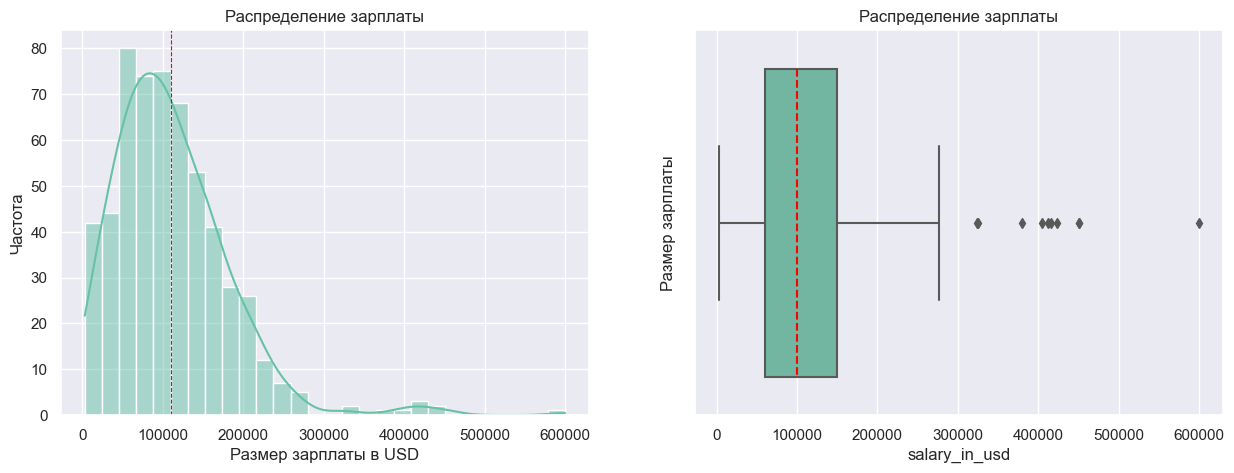

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x=data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в USD', ylabel='Частота')
axes[0].set_title('Распределение зарплаты')
axes[0].axvline(data['salary_in_usd'].mean(), color='red',
                linestyle='--', linewidth=0.8)

sns.boxplot(x=data['salary_in_usd'], ax=axes[1], orient='h',
            medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплаты')
axes[1].set_title('Распределение зарплаты')

plt.show()

**Вывод:** Распределение зарплат отлично от нормального, имеются выбросы.

In [12]:
# удалим выбросы.
data = data[(data['salary_in_usd']<300000)]

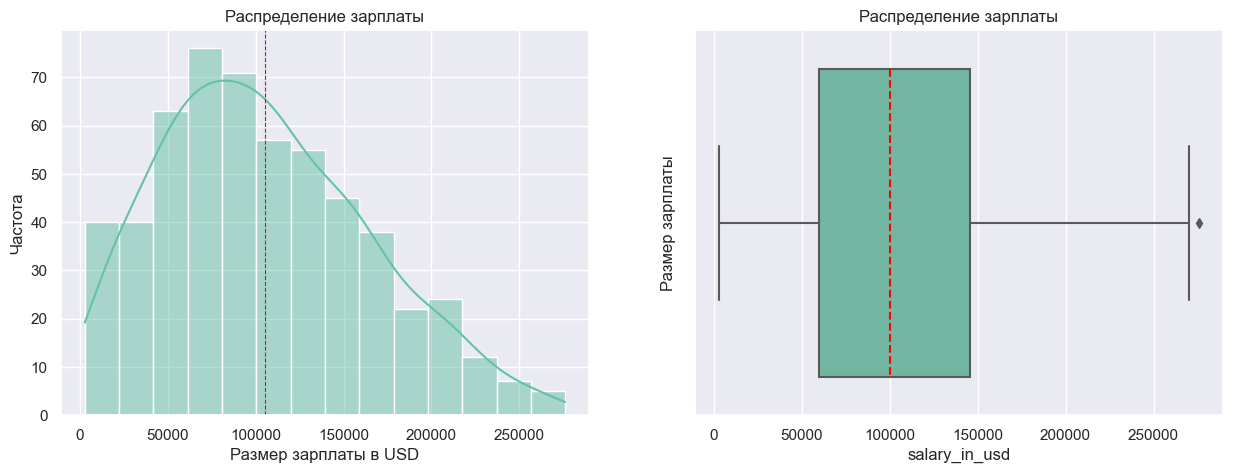

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(x=data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в USD', ylabel='Частота')
axes[0].set_title('Распределение зарплаты')
axes[0].axvline(data['salary_in_usd'].mean(), color='red',
                linestyle='--', linewidth=0.8)

sns.boxplot(x=data['salary_in_usd'], ax=axes[1], orient='h',
            medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплаты')
axes[1].set_title('Распределение зарплаты')

plt.show()

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
#### Признак - work_year

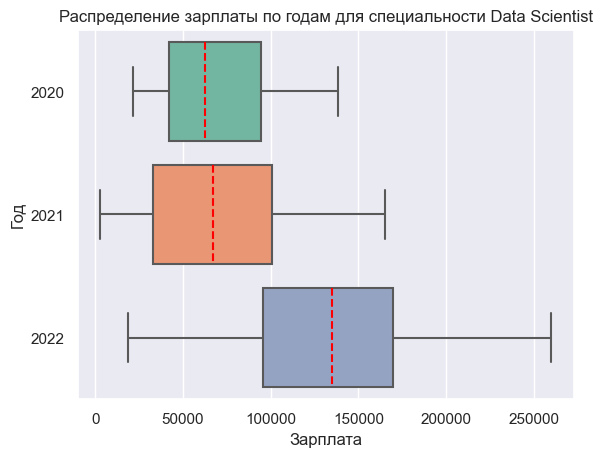

In [14]:
ax = sns.boxplot(data=data[data['job_title'] == 'Data Scientist'], x='salary_in_usd', y='work_year', orient='h',
                 medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата', ylabel='Год')
plt.title('Распределение зарплаты по годам для специальности Data Scientist')
plt.show()

In [15]:
data_agg = data[data['job_title'] == 'Data Scientist'].groupby(
    'work_year')['salary_in_usd'].describe().round(2)
print('Зарплата в зависимости от года для специализации Data Scientist')
data_agg

Зарплата в зависимости от года для специализации Data Scientist


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,20.0,69669.05,33268.11,21669.0,41768.00,62726.0,94677.75,138350.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


**Вывод:** Рост зарплаты с 2020 по 2021 незначительный. В 2022 зарплата заметно увеличилась.


### Общий объём работы, выполняемой удалённо
#### Признак - remote_ratio

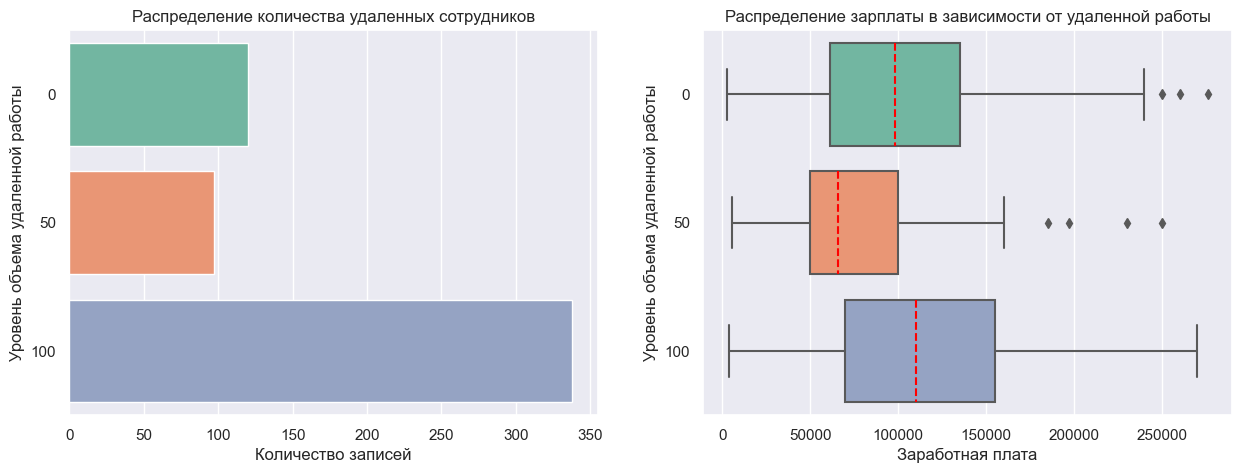

In [16]:
'''
Общий объём работы, выполняемой удалённо. Возможные значения:
     0 — удалённой работы нет (менее 20 %);
     50 — частично удалённая работа;
     100 — полностью удалённая работа (более 80 %).
'''
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=data, y='remote_ratio', ax=axes[0])
axes[0].set(xlabel='Количество записей',
            ylabel='Уровень объема удаленной работы')
axes[0].set_title('Распределение количества удаленных сотрудников')

sns.boxplot(data=data, x='salary_in_usd', y='remote_ratio', orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[1])
axes[1].set(xlabel='Заработная плата',
            ylabel='Уровень объема удаленной работы')
axes[1].set_title('Распределение зарплаты в зависимости от удаленной работы')

plt.show()

**Вывод:** Преобладает полностью удаленная работа, также заработная плата у "удаленщиков" выше остальных видов работы и примерно мопоставима у тех, кто работает в офисе

### Опыт работы на должности в течение года
#### Признак - experience_level

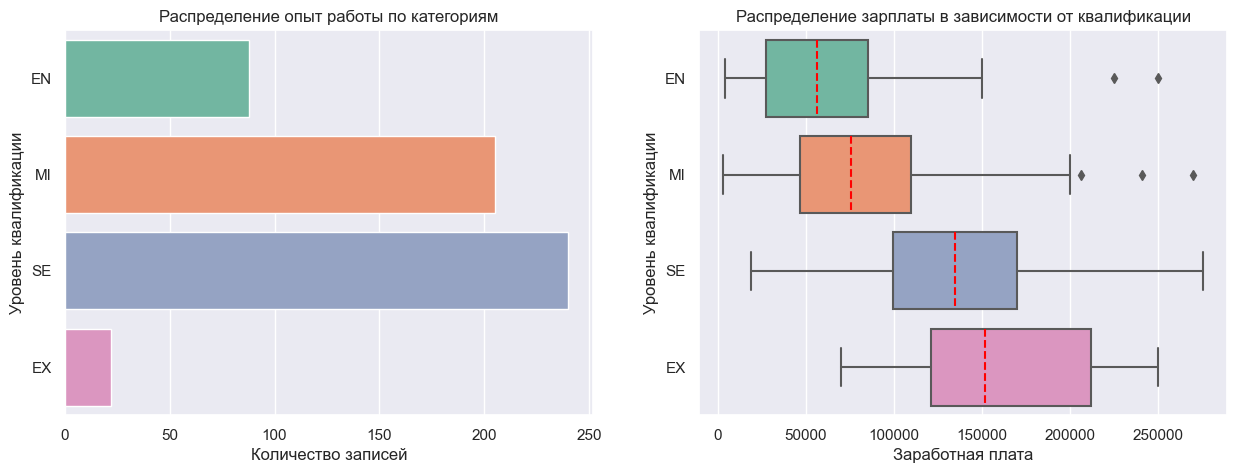

In [17]:
experience = ['EN', 'MI', 'SE', 'EX']
'''
Опыт работы на этой должности в течение года со следующими возможными значениями:
        EN — Entry-level/Junior;
        MI — Mid-level/Intermediate;
        SE — Senior-level/Expert;
        EX — Executive-level/Director.
'''

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=data, y='experience_level', order=experience, ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Уровень квалификации')
axes[0].set_title('Распределение опыт работы по категориям')

sns.boxplot(data=data, x='salary_in_usd', y='experience_level', orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[1], order=experience)
axes[1].set(xlabel='Заработная плата', ylabel='Уровень квалификации')
axes[1].set_title('Распределение зарплаты в зависимости от квалификации')

plt.show()

**Вывод:** Больше всего специальностей находится в грумме MI и SE (мидл и сеньер), очень мало уровня эксперта. При этом уровень заработной платы растет в зависимости от уровня квалификации.
Так медианный уровень заработной платы каждого последующего уровня примерно равен или выше верхнего квантиля предыдущего уровня.<br>
Уровень зарбплаты у экспертов - на самом высоком уровне.

### Тип трудоустройства 
#### Признак - employment_type

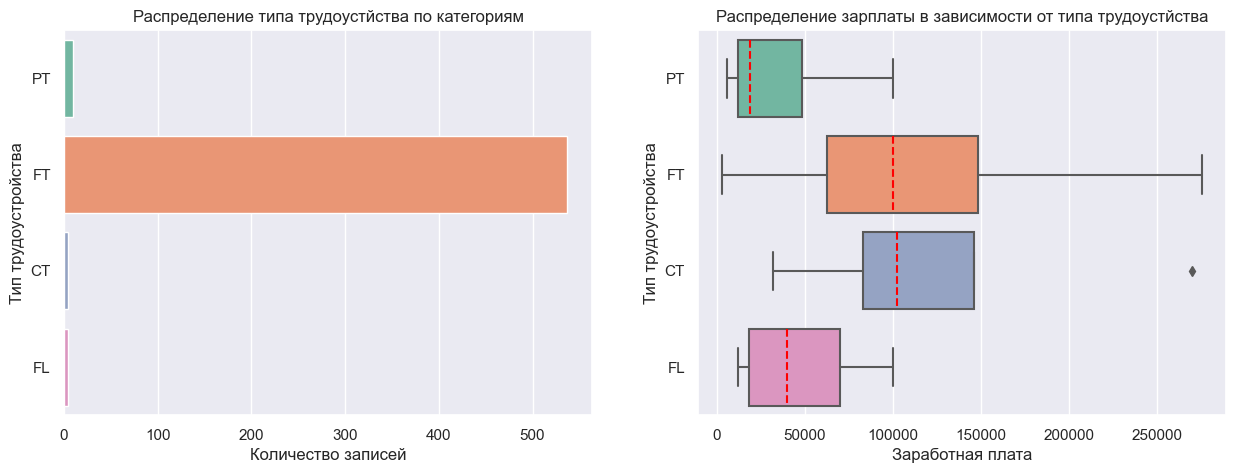

In [18]:
employment = ['PT', 'FT', 'CT', 'FL']
'''Тип трудоустройства для этой роли:
        PT — неполный рабочий день;
        FT — полный рабочий день;
        CT — контракт;
        FL — фриланс.
'''
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=data, y='employment_type', order=employment, ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Тип трудоустройства')
axes[0].set_title('Распределение типа трудоустйства по категориям')

sns.boxplot(data=data, x='salary_in_usd', y='employment_type', orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[1], order=employment)
axes[1].set(xlabel='Заработная плата', ylabel='Тип трудоустройства')
axes[1].set_title('Распределение зарплаты в зависимости от типа трудоустйства')

plt.show()

**Вывод:** Наиболее распространен тип трудоусторйства - FT — полный рабочий день. 
Остальные типы занимают значительно низкие доли.
А наиболее высоки зарплаты у тх, кто работает по контракту, что ожидаемо. 
По типу трудоусторйства "FT — полный рабочий день" очень много выбросов. 

### Роль, в которой соискатель работал в течение года

#### Признак - job_title

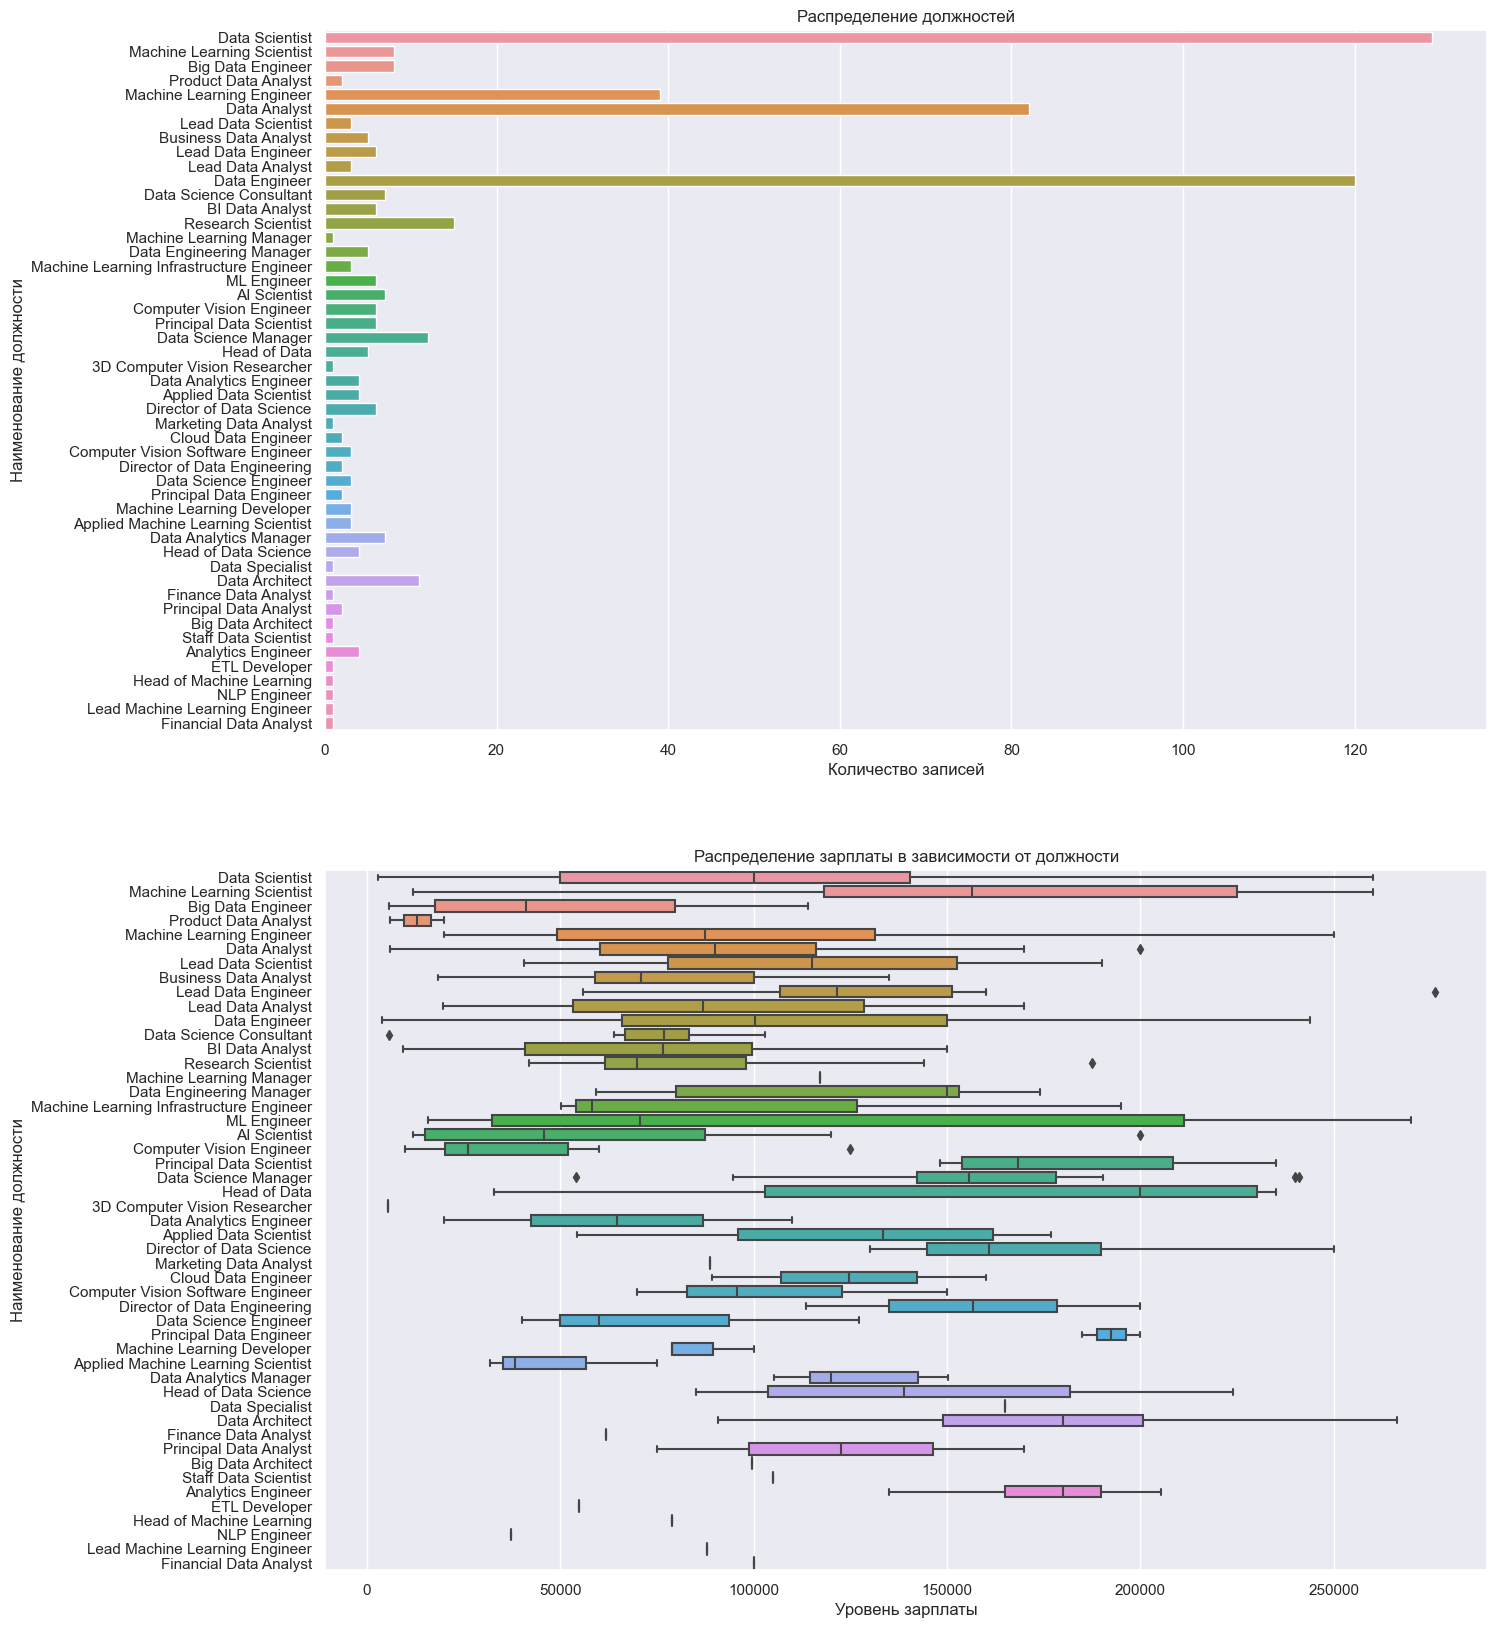

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))

sns.countplot(data=data, y='job_title', ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Наименование должности')
axes[0].set_title('Распределение должностей')

sns.boxplot(data=data, y='job_title', x='salary_in_usd', ax=axes[1])
axes[1].set(xlabel='Уровень зарплаты', ylabel='Наименование должности')
axes[1].set_title('Распределение зарплаты в зависимости от должности')

plt.show()

**Вывод:** ТОП-5 профессий: Data Scientist, Data Engineer, Data Analyst, Maschine Learning Engineer, Research Scientist

Уровень заработной платы у этих профессий находится примерно в одной плоскости по отношению к другим, самые высокооплачиваемые профессии это Principal Data Scientist и Financial Data Analyst

### Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
#### Признак - employee_residence


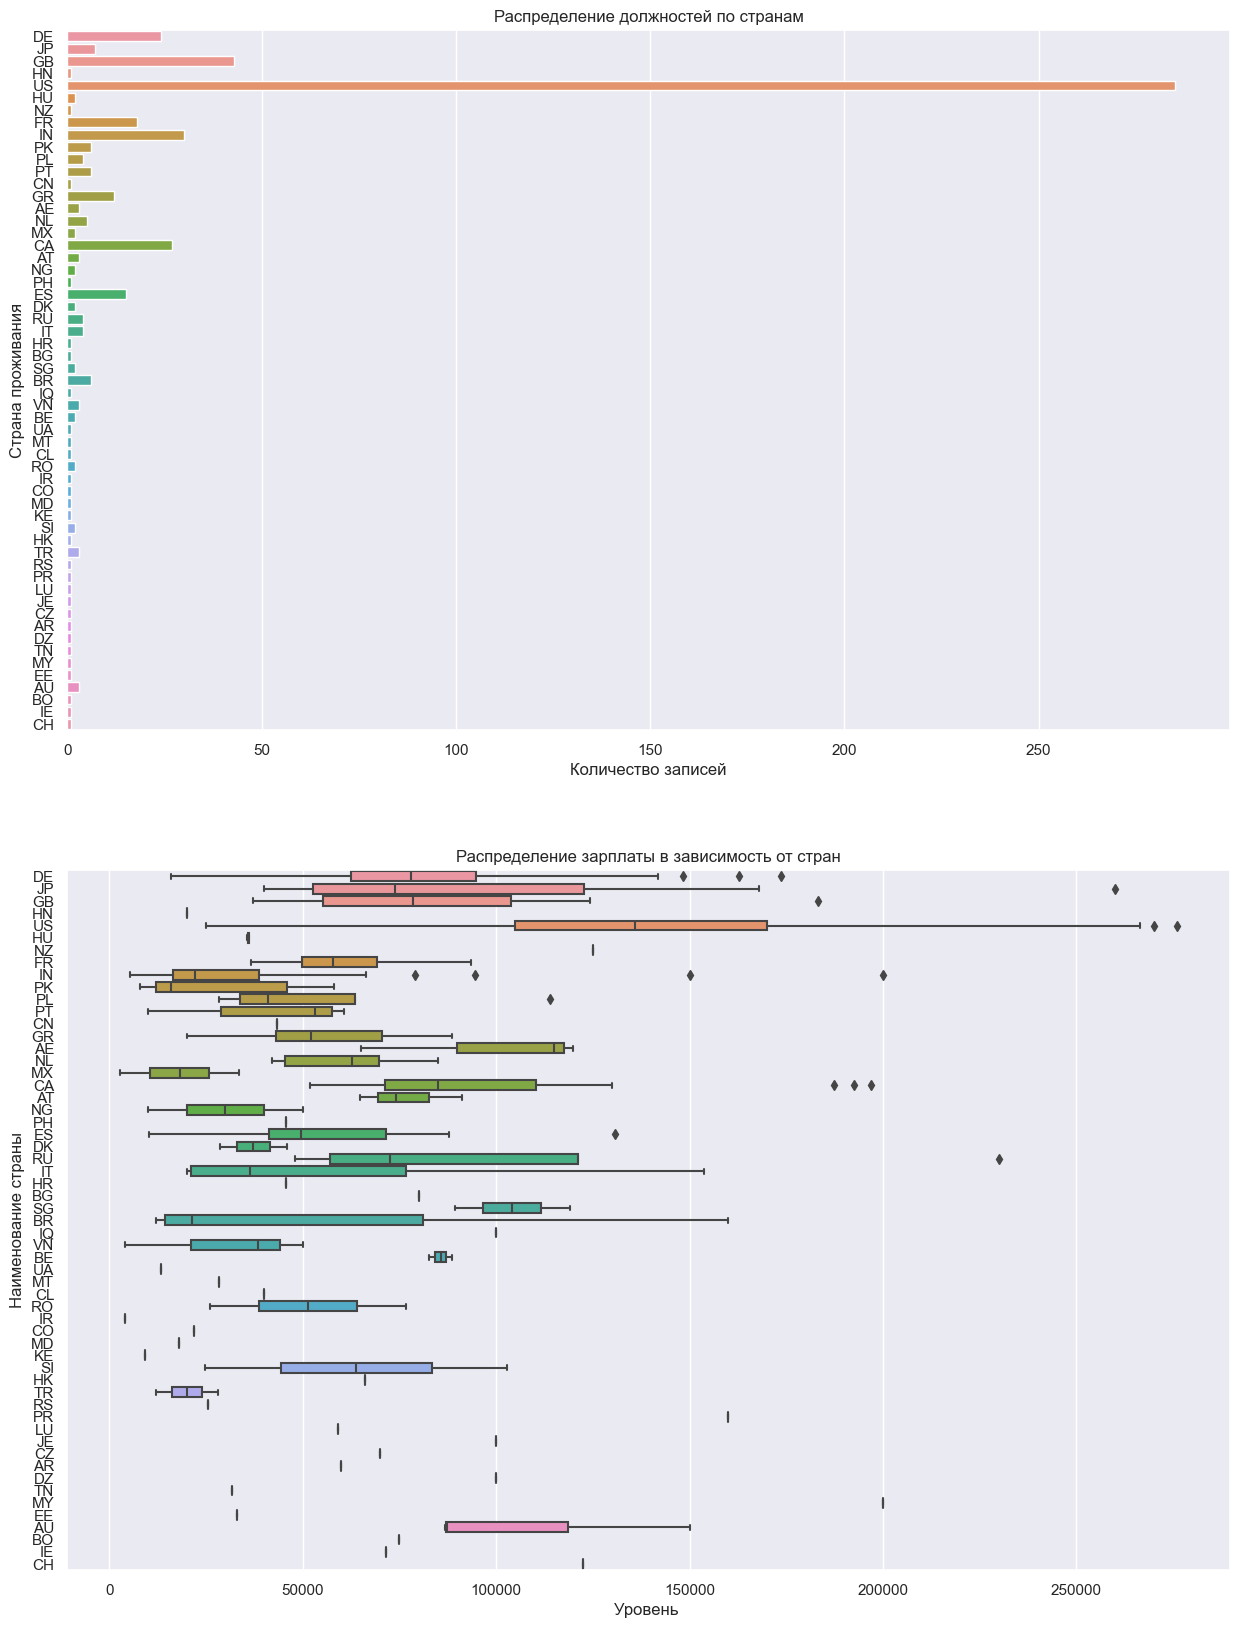

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))

sns.countplot(data=data, y='employee_residence', ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Страна проживания')
axes[0].set_title('Распределение должностей по странам')

sns.boxplot(data=data, y='employee_residence', x='salary_in_usd', ax=axes[1])
axes[1].set(xlabel='Уровень ', ylabel='Наименование страны')
axes[1].set_title('Распределение зарплаты в зависимость от стран')

plt.show()

**Вывод:** Большинство сотрудников работают в США. 

Самый высокий уровень зарплаты находится там же, возможно один признак коррелируется с другим.

### Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
#### Признак - company_location

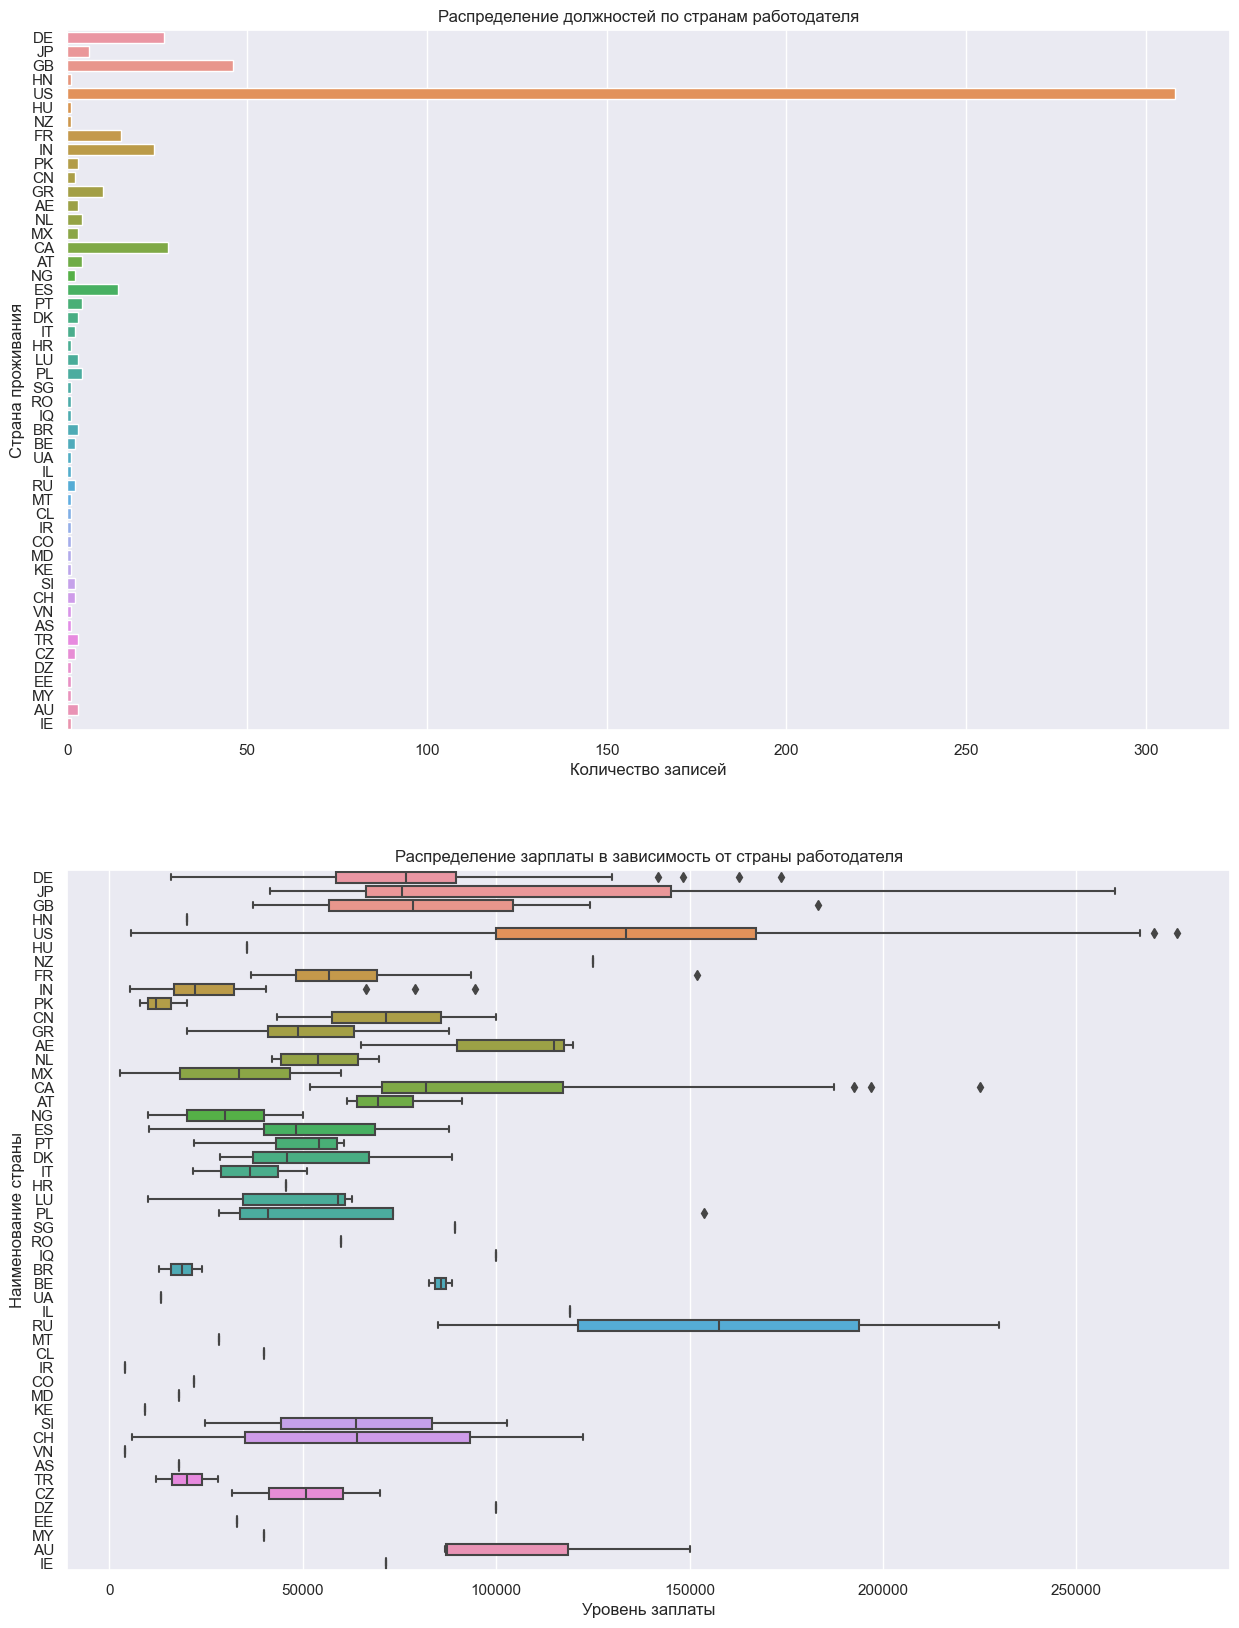

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(15, 20))
sns.countplot(data=data, y='company_location', ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Страна проживания')
axes[0].set_title('Распределение должностей по странам работодателя')

sns.boxplot(data=data, y='company_location', x='salary_in_usd', ax=axes[1])
axes[1].set(xlabel='Уровень заплаты', ylabel='Наименование страны')
axes[1].set_title(
    'Распределение зарплаты в зависимость от страны работодателя')

plt.show()

**Вывод:** Среди работадателей в США находятся на втором месте, самый высокий уровень в РФ, на третем месте Япония

### Среднее количество людей, работавших в компании в течение года
#### Признак - company_size


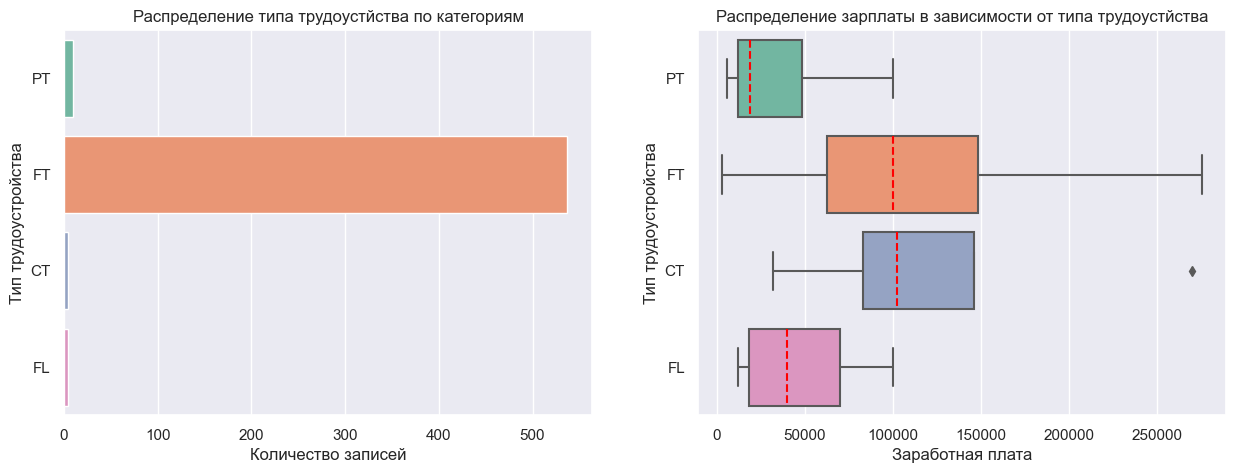

In [22]:
employment = ['PT', 'FT', 'CT', 'FL']
'''Тип трудоустройства для этой роли:
        PT — неполный рабочий день;
        FT — полный рабочий день;
        CT — контракт;
        FL — фриланс.
'''
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=data, y='employment_type', order=employment, ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Тип трудоустройства')
axes[0].set_title('Распределение типа трудоустйства по категориям')

sns.boxplot(data=data, x='salary_in_usd', y='employment_type', orient='h',
            medianprops={"color": "red", "linestyle": '--'}, ax=axes[1], order=employment)
axes[1].set(xlabel='Заработная плата', ylabel='Тип трудоустройства')
axes[1].set_title('Распределение зарплаты в зависимости от типа трудоустйства')

plt.show()

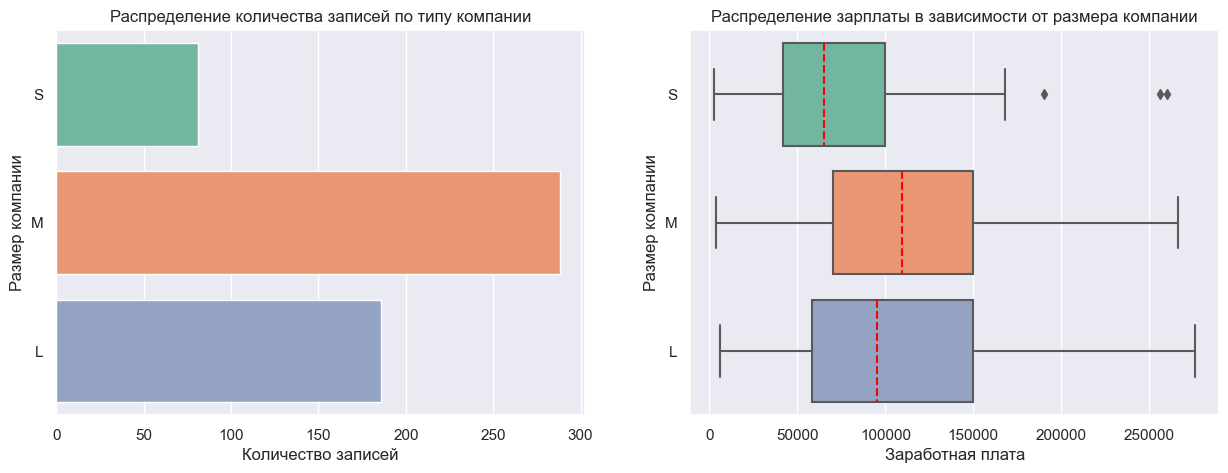

In [23]:
'''
   S — менее 50 сотрудников (небольшая компания);
   M — от 50 до 250 сотрудников (средняя компания);
   L — более 250 сотрудников (крупная компания).
'''

comp_size = ['S', 'M', 'L']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=data, y='company_size', order=comp_size, ax=axes[0])
axes[0].set(xlabel='Количество записей', ylabel='Размер компании')
axes[0].set_title('Распределение количества записей по типу компании')

sns.boxplot(data=data, x='salary_in_usd', y='company_size', orient='h',
            medianprops={"color": "red", "linestyle": '--'}, order=comp_size, ax=axes[1])
axes[1].set(xlabel='Заработная плата', ylabel='Размер компании')
axes[1].set_title('Распределение зарплаты в зависимости от размера компании')

plt.show()

**Вывод:** Больше всего специалистов занятов в средних компаниях. 

Также заметно, что медиана заработной платы в таких компаниях выше, чем в маленьких и больших

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

In [24]:
mask = (data['job_title'] == 'Data Scientist') | (
    data['job_title'] == 'Data Engineer')

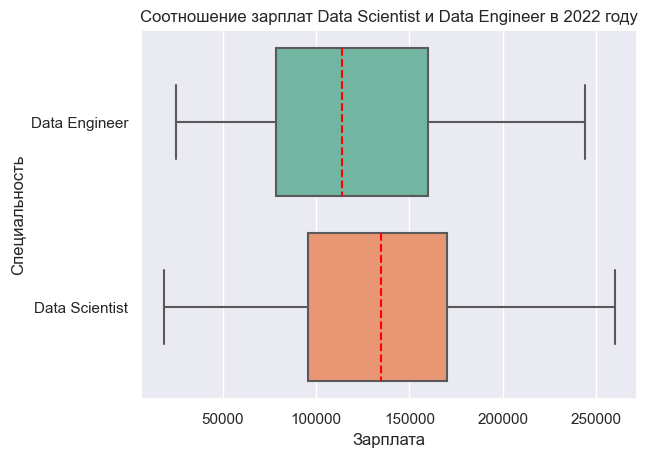

In [25]:
ax = sns.boxplot(data=data[mask & (data['work_year'] == 2022)], x='salary_in_usd',
                 y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата', ylabel='Специальность')
plt.title('Cоотношение зарплат Data Scientist и Data Engineer в 2022 году')
plt.show()

In [26]:
data_agg = data[mask & (data['work_year'] == 2022)].groupby(
    'job_title')['salary_in_usd'].describe().round(2)
print('Cоотношение зарплат Data Scientist и Data Engineer в 2022 году')
data_agg

Cоотношение зарплат Data Scientist и Data Engineer в 2022 году


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,78.0,122096.04,53544.36,25000.0,78526.0,114000.0,160000.0,243900.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


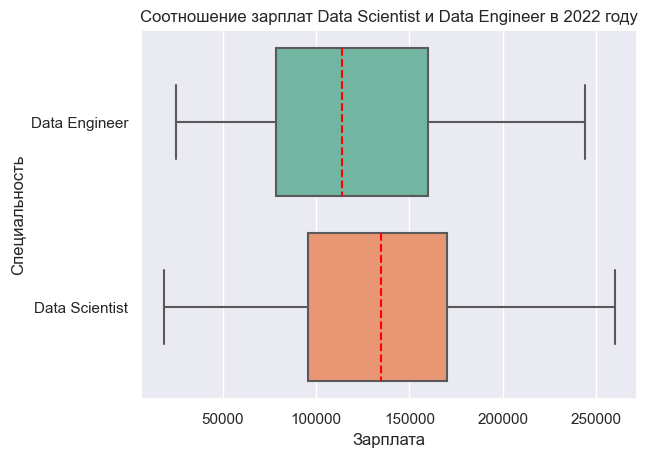

Cоотношение зарплат Data Scientist и Data Engineer в 2022 году


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,78.0,122096.04,53544.36,25000.0,78526.0,114000.0,160000.0,243900.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


In [27]:
ax = sns.boxplot(data=data[mask & (data['work_year'] == 2022)], x='salary_in_usd',
                 y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата', ylabel='Специальность')
plt.title('Cоотношение зарплат Data Scientist и Data Engineer в 2022 году')
plt.show()

data_agg = data[mask & (data['work_year'] == 2022)].groupby(
    'job_title')['salary_in_usd'].describe().round(2)
print('Cоотношение зарплат Data Scientist и Data Engineer в 2022 году')
data_agg

**Вывод:** У дата сайентистов зарплаты выше, чем у дата инженеров


### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

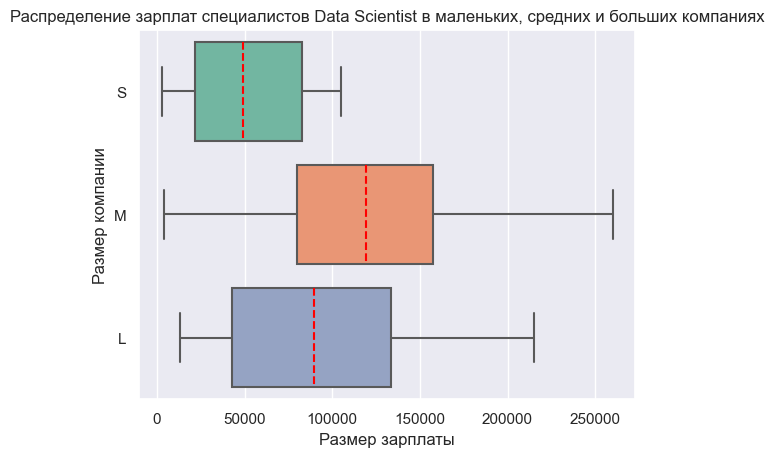

In [28]:
comp_size = ['S', 'M', 'L']
ax = sns.boxplot(data=data[data['job_title'] == 'Data Scientist'], x='salary_in_usd', y='company_size', orient='h',
                 medianprops={"color": "red", "linestyle": '--'}, order=comp_size)
ax.set(xlabel='Размер зарплаты', ylabel='Размер компании')
plt.title('Распределение зарплат специалистов Data Scientist в маленьких, средних и больших компаниях')
plt.show()

**Вывод:** Уровень зарплат дата сайентистов выше в комапаниях среднего размера. Минимальный  уровень зарплат в небольших команиях. 

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

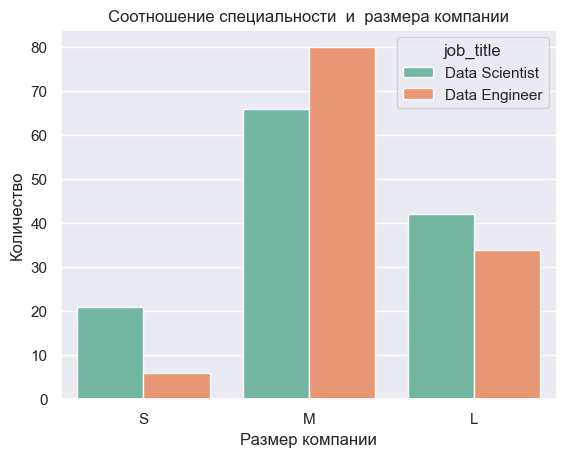

In [29]:
comp_size = ['S', 'M', 'L']
ax = sns.countplot(data=data[mask], hue=data[mask]
                   ['job_title'], x='company_size', order=comp_size)
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение специальности  и  размера компании')
plt.show()

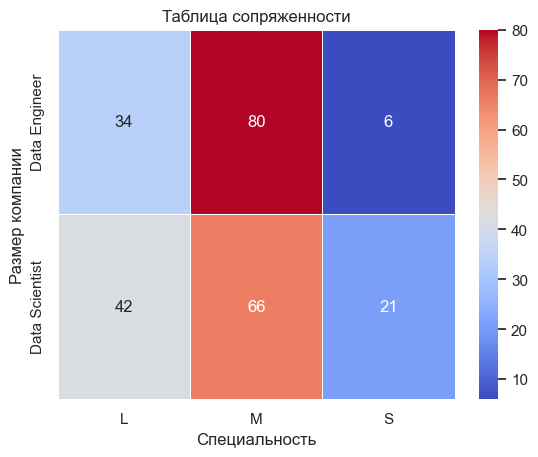

In [30]:
cross_tab = pd.crosstab(
    index=data[mask]['job_title'], columns=data['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5,
                 fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Специальность', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()

**Вывод:** Вакансий на Data Engineer в средних компаниях больше чем на Data Scientist. В небольших и крупных компаниях ситуация обратная.


# Статистический анализ данных

In [31]:
# Задаём уровень значимости
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Для ответа на этот вопрос необходимо попарно сравнить зарлапту за три года: 2020-2021, 2021-2022

**2020 - 2021 год**

*Нулевая гипотеза* ($H_0$): зарплата за 2020 год ($μ_1$) статистически больше, либо такая же как за 2021 год ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): заплата за 2021 год ($μ_2$) статистически меньше, чем зарплата за 2020 год ($μ_1$).

$$ H_1 : μ_1 < μ_2$$

**2021 - 2022 год**

*Нулевая гипотеза* ($H_0$): зарплата за 2021 год ($μ_2$) статистически больше, либо такая же как за 2022 год ($μ_3$).

$$ H_0 : μ_2 >= μ_3$$

*Альтернативная гипотеза* ($H_1$): заплата за 2022 год ($μ_3$) статистически меньше, чем зарплата за за 2021 год ($μ_2$).

$$ H_1 : μ_2 < μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [32]:
# Датасетты по годам
DS20 = data[(data['job_title'] == 'Data Scientist')
                & (data['work_year'] == 2020)]
DS21 = data[(data['job_title'] == 'Data Scientist')
                & (data['work_year'] == 2021)]
DS22 = data[(data['job_title'] == 'Data Scientist')
                & (data['work_year'] == 2022)]

In [33]:
# Проводим тесты Шапиро-Уилка
print('\n Тест для зарплаты за 2020 год:')
result = stats.shapiro(DS20['salary_in_usd'])
decision_normality(result[1])

print('\n Тест для зарплаты за 2021 год:')
result = stats.shapiro(DS21['salary_in_usd'])
decision_normality(result[1])

print('\n Тест для зарплаты за 2022 год:')
result = stats.shapiro(DS22['salary_in_usd'])
decision_normality(result[1])


 Тест для зарплаты за 2020 год:
p-value = 0.145
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

 Тест для зарплаты за 2021 год:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

 Тест для зарплаты за 2022 год:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах»? — Количественный.
* Сколько сравниваемых групп? — Две. 
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать Двухвыборочный t-критерий

**Проведём тесты**

In [34]:
# 2020-2021
# Проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(DS20['salary_in_usd'], DS21['salary_in_usd'])
p = result[1]
print('p-value = {:.3f}'.format(p))

# Интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# Проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(
    DS20['salary_in_usd'], DS21['salary_in_usd'], alternative='less', equal_var=(p > alpha))

decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.059
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.481
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [35]:
# 2021-2022
# Перед использованием необходимо установить равенство (или неравенство) дисперсий в выборках
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(DS21['salary_in_usd'], DS22['salary_in_usd'])
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(
    DS21['salary_in_usd'], DS22['salary_in_usd'], alternative='less', equal_var=(p > alpha))

decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод** 

Нельзя сказать, что наблюдается ежегодный рост зарплат у специалистов Data Scientist с 2020 по 2022. Поскольку зарплата специалистов Data Scientist в 2022 году выросла по сравнению с 2021 годом, а в 2021 году рост зарплаты относительно 2020 статистически не подтверждается.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): зарплата Data Scientist($μ_1$) статистически меньше либо равна зарплате Data Engineer($μ_2$) в 2022 году.

$$ H_0: μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): зарплата Data Scientist($μ_1$) статистически больше зарплаты Data Engineer($μ_2$) в 2022 году.

$$ H_1: μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [36]:
DE22 = data[(data['job_title'] == 'Data Engineer')
                & (data['work_year'] == 2022)]

In [37]:
# проводим тест Шапиро-Уилка
print('\n Тест для зарплаты DS за 2022 год:')
result = stats.shapiro(DS22['salary_in_usd'])
decision_normality(result[1])

print('\n Тест для зарплаты DE за 2022 год:')
result = stats.shapiro(DE22['salary_in_usd'])
decision_normality(result[1])


 Тест для зарплаты DS за 2022 год:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

 Тест для зарплаты DE за 2022 год:
p-value = 0.021
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах»? — Количественный.
* Сколько сравниваемых групп? — Две. 
* Группы зависимы? — Нет. 
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можо использовать U-критерий Манна — Уитни.

**Проведём тесты**

In [38]:
# Тест по U-критерию Манна — Уитни
_, p = stats.mannwhitneyu(DS22['salary_in_usd'], DE22['salary_in_usd'], alternative='greater')
decision_hypothesis(p)

p-value = 0.128
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод** 

Нет оснований утверждать, что зарплата дата-сайентистов выше, чем у дата инженеров.
Это противоречит выводу, полученному после визуального анализа, согласно которому у дата-сайентистов зарплаты выше, чем у дата инженеров.
Возможно на это повлияли выбросы по зарплате, либо отсутвие данных по зарплате уровня EX у дата-сайентистов. 

### Дополнительное исследование
Попытаемся выяснить, что могло повлиять на противоречивые результаты визуального и сттистического анализа

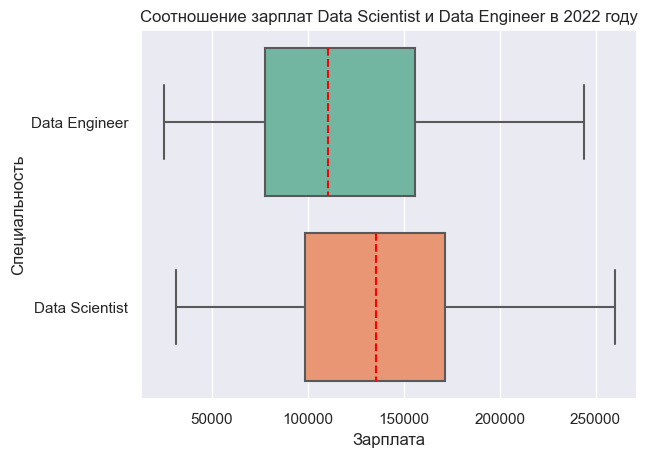

Cоотношение зарплат Data Scientist и Data Engineer в 2022 году


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,75.0,118206.55,50719.19,25000.0,77733.0,110500.0,155800.0,243900.0
Data Scientist,64.0,133131.39,54367.40,31615.0,98407.5,135810.0,171500.0,260000.0


In [39]:
# Отфильтруем данных по зарплате уровня EX и нижнюю границу по зарплате. 
mask2 = ((data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')) & (
    (data['experience_level'] != 'EX') & (data['salary_in_usd'] > 24900) & (data['work_year'] == 2022))

ax = sns.boxplot(data=data[mask2], x='salary_in_usd',
                 y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата', ylabel='Специальность')
plt.title('Cоотношение зарплат Data Scientist и Data Engineer в 2022 году')
plt.show()

data_agg = data[mask2].groupby(
    'job_title')['salary_in_usd'].describe().round(2)
print('Cоотношение зарплат Data Scientist и Data Engineer в 2022 году')
data_agg

In [40]:
DE22cut = DE22[DE22['experience_level']!='EX']

In [41]:
DS22cut = DS22[DS22['salary_in_usd'] > 24900]

In [42]:
# Варинант 1 датасета DS, где нижняя граница отличается от нижней границы зарплаты DE не на много
print('\n Тест для зарплаты DScut за 2022 год:')
result = stats.shapiro(DS22cut['salary_in_usd'])
decision_normality(result[1])

print('\n Тест для зарплаты DE за 2022 год:')
result = stats.shapiro(DE22['salary_in_usd'])
decision_normality(result[1])


 Тест для зарплаты DScut за 2022 год:
p-value = 0.545
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

 Тест для зарплаты DE за 2022 год:
p-value = 0.021
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [43]:
# Тест по U-критерию Манна — Уитни
_, p = stats.mannwhitneyu(DS22cut['salary_in_usd'], DE22['salary_in_usd'], alternative='greater')
decision_hypothesis(p)

p-value = 0.095
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод** 

Нет оснований утверждать, что зарплата дата-сайентистов выше, чем у дата инженеров.

In [44]:
# Варинат 2 датасета, без учета зарплат DE с опытом работы EX — Executive-level/Director
print('\n Тест для зарплаты DS за 2022 год:')
result = stats.shapiro(DS22['salary_in_usd'])
decision_normality(result[1])

print('\n Тест для зарплаты DEcut за 2022 год:')
result = stats.shapiro(DE22cut['salary_in_usd'])
decision_normality(result[1])


 Тест для зарплаты DS за 2022 год:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

 Тест для зарплаты DEcut за 2022 год:
p-value = 0.042
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [45]:
# Тест по U-критерию Манна — Уитни
_, p = stats.mannwhitneyu(DS22['salary_in_usd'], DE22cut['salary_in_usd'], alternative='greater')
decision_hypothesis(p)

p-value = 0.064
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод** 

Нет оснований утверждать, что зарплата дата-сайентистов выше, чем у дата инженеров.

In [46]:
# Вариант 3, когда нижний  преджел по зарплате DS и DE около 25 тыс, и убраны вакансии DE опытом
# EX — Executive-level/Director, которых нет в датасете DS

In [47]:
# проводим тест Шапиро-Уилка
print('\n Тест для зарплаты DS за 2022 год:')
result = stats.shapiro(DS22cut['salary_in_usd'])
decision_normality(result[1])

print('\n Тест для зарплаты DE за 2022 год:')
result = stats.shapiro(DE22cut['salary_in_usd'])
decision_normality(result[1])


 Тест для зарплаты DS за 2022 год:
p-value = 0.545
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

 Тест для зарплаты DE за 2022 год:
p-value = 0.042
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [48]:
# Тест по U-критерию Манна — Уитни
_, p = stats.mannwhitneyu(DS22cut['salary_in_usd'], DE22cut['salary_in_usd'], alternative='greater')
decision_hypothesis(p)

p-value = 0.045
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод** 

Только при таких ограничениях (когда нижний  преджел по зарплате DS и DE около 25 тыс, и убраны вакансии DE с опытом EX — Executive-level/Director, которых нет в датасете DS) можно утверждать, что зарплата дата-сайентистов выше, чем у дата инженеров.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: зарплата специалистов Data Scientist в компаниях разных размеров не отличается: небольшие($μ_1$), средние ($μ_2$), крупные ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: зарплата специалистов Data Scientist в компаниях разных разная: небольшие($μ_1$), средние ($μ_2$), крупные ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [49]:
# Фильтры по размерам компаний
DSS = (data['job_title']=='Data Scientist') & (data['company_size']=='S')
DSM = (data['job_title']=='Data Scientist') & (data['company_size']=='M')
DSL = (data['job_title']=='Data Scientist') & (data['company_size']=='L')

In [50]:
# Проводим тест Шапиро-Уилка
print('S — менее 50 сотрудников :')
result = stats.shapiro(data[DSS]['salary_in_usd'])
decision_normality(result[1])

print('M — от 50 до 250 сотрудников:')
result = stats.shapiro(data[DSM]['salary_in_usd'])
decision_normality(result[1])

print('L — более 250 сотрудников:')
result = stats.shapiro(data[DSL]['salary_in_usd'])
decision_normality(result[1])

S — менее 50 сотрудников :
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
M — от 50 до 250 сотрудников:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
L — более 250 сотрудников:
p-value = 0.030
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах»? — Количественный.
* Сколько сравниваемых групп? — Три. 
* Группы зависимы? — Нет. 
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можо использовать Критерий Краскела — Уоллиса (однофакторный дисперсионный анализ на рангах).

**Проведём тесты**

In [51]:
# проводим тест
_, p = stats.kruskal(data[DSS]['salary_in_usd'], data[DSM]['salary_in_usd'], data[DSL]['salary_in_usd'])
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Зарплаты в компаниях разного размера различны. Проверим вывод визуального анализа, что уровень зарплат дата сайентистов выше в комапаниях среднего размера. Минимальный  уровень зарплат в небольших команиях. 
Сравним попарно зарплату в компаниях разного  размера.

   
**Сравнение компаний размера: M - L**

*Нулевая гипотеза* ($H_0$): заплата в копманиях M ($μ_2$) статистически меньше, либо такая же как в L ($μ_3$).

$$ H_0 : μ_2 <= μ_3$$

*Альтернативная гипотеза* ($H_1$): заплата в копманиях M ($μ_2$) статистически больше, чем в L ($μ_3$).

$$ H_1 : μ_2 > μ_3$$

**Сравнение компаний размера: L - S**

*Нулевая гипотеза* ($H_0$): заплата в копманиях L ($μ_3$) статистически меньше, либо такая же как в S ($μ_1$).

$$ H_0 : μ_3 <= μ_1$$

*Альтернативная гипотеза* ($H_1$): заплата в копманиях L ($μ_3$) статистически больше, чем в S ($μ_1$).

$$ H_1 : μ_3 > μ_1$$


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах»? — Количественный.
* Сколько сравниваемых групп? — Две. 
* Группы зависимы? — Нет. 
* Признак распределён по нормальному закону? — Да для пары S и M. Нет в парах для L

Для проверки нашей гипотезы можно использовать:
* для пары S и M  - Двухвыборочный t-критерий (t-test) 
* для пар с L - U-критерий Манна — Уитни.

**Проведём тесты**


In [52]:
# Сравним зарплаты в компаниях M и L 
_, p = stats.mannwhitneyu(data[DSM]['salary_in_usd'], data[DSL]['salary_in_usd'], alternative='greater')
decision_hypothesis(p)

p-value = 0.013
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [53]:
# Сравним зарплаты в компаниях L и S 
_, p = stats.mannwhitneyu(data[DSL]['salary_in_usd'], data[DSS]['salary_in_usd'], alternative='greater')
decision_hypothesis(p)

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Максимальные зарплаты в команиях среднего размера, а минимаьлные в небольших компаниях

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: нет связи между наличием должностей Data Scientist и Data Engineer и размером компании.

*Альтернативная гипотеза*: есть связь между наличием должностей Data Scientist и Data Engineer и размером компании.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [54]:
# Cоставляем таблицу сопряжённости

contingency = pd.crosstab(data[mask]['job_title'], data['company_size'])
contingency

company_size,L,M,S
job_title,,,
Data Engineer,34,80,6
Data Scientist,42,66,21


In [55]:
# Проводим тест
_, p, _, _ = stats.chi2_contingency(contingency)
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая связь между наличием должностей Data Scientist и Data Engineer и размером компании